## NLP Class Assignment 6

In [12]:
# !pip install pandarallel
# !pip install gensim --upgrade
# !pip install pyLDAvis --upgrade

In [13]:
import pandas as pd

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)

import nltk as nltk
import nltk.corpus  
from nltk.text import Text
import re

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from nltk.metrics import jaccard_distance
from itertools import combinations
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from nltk.metrics import jaccard_distance
from itertools import combinations
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns

from pandarallel import pandarallel
import multiprocessing
pandarallel.initialize(nb_workers = multiprocessing.cpu_count()-1, use_memory_fs=False)

import os
import warnings
warnings.simplefilter('ignore')

import gensim
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import CoherenceModel

# import pyLDAvis.gensim
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

import matplotlib.pyplot as plt

nltk.download('all')

INFO: Pandarallel will run on 15 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\yomaa\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\yomaa\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\yomaa\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\yomaa\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     C:\Users\yomaa\AppData\Roaming\nltk_data...
[nltk_data]    | 

True

#### Read news data

In [14]:
news_path = 'https://storage.googleapis.com/msca-bdp-data-open/news/nlp_a_6_news.json'
news_df = pd.read_json(news_path, orient='records', lines=True)

print(f'Sample contains {news_df.shape[0]:,.0f} news articles')
news_df.head(2)

Sample contains 9,962 news articles


,url,date,language,title,text
0,http://oaklandnewsnow.com/breaking-bts-announces-las-vegas-us-concert-date-in-2022/,2022-02-24,en,"BREAKING: BTS Announces LAS VEGAS, US Concert Date in 2022! | Oakland News Now - Oakland News, SF Bay Area, East Bay, California, World","BREAKING: BTS Announces LAS VEGAS, US Concert Date in 2022! | Oakland News Now - Oakland News, SF Bay Area, East Bay, California, WorldSorry, you have Javascript Disabled! To see this page as it is meant to appear, please enable your Javascript!BREAKING: BTS Announces LAS VEGAS, US Concert Date in 2022! | Oakland News Now - Oakland News, SF Bay Area, East Bay, California, WorldSkip to contentMenuSearch for:SearchOakland News Now – Oakland News, SF Bay Area, East Bay, California, WorldOakland..."
1,http://www.newsdzezimbabwe.co.uk/2022/04/mai-tt-weds.html,2022-04-09,en,MAI TT WEDS newsdzeZimbabweNewsdzeZimbabwe,"MAI TT WEDS newsdzeZimbabweNewsdzeZimbabweskip to main | skip to sidebarHomeAboutContactAdvertiseNewsdzeZimbabweOur Zimbabwe Our NewsHomeNewsBusinessEntertainmentSaturday, 9 April 2022MAI TT WEDSSaturday, April 09, 2022 NewsdzeZimbabwe 0 Best moments... @Chakariboy @NyamayaroArron @restmutore @Lattynyangu pic.twitter.com/MsrhcFXUJj— H-Metro (@HMetro_) April 9, 2022 Posted in: Share to TwitterShare to FacebookOlder PostHome0comments: Post a CommentFollow NewsdzeZimbabweRecent..."


#### Read Tweets data

In [15]:
tweets_path = 'https://storage.googleapis.com/msca-bdp-data-open/tweets/nlp_a_6_tweets.json'
tweets_df = pd.read_json(tweets_path, orient='records', lines=True)
print(f'Sample contains {tweets_df.shape[0]:,.0f} tweets')
tweets_df.head(2)

Sample contains 9,941 tweets


,id,lang,date,name,retweeted,text
0,1484553027222741001,en,2022-01-21,Dylan Green,RT,*Microsoft has entered the chat* https://t.co/Uz3pZrk6B3
1,1505486305102557184,en,2022-03-20,Rahim Rajwani,,"""I actually use an @Android phone. Some #Android manufacturers pre-install @Microsoft software in a way that makes it easy for me. They’re more flexible about how the software connects up with the OS. So that’s what I ended up getting used to.""\nhttps://t.co/C0VjfS9PUO"


In [16]:


def clean_text(text):
    import nltk
    import re

    stopwords = set(nltk.corpus.stopwords.words('english'))
    lemmatizer = nltk.WordNetLemmatizer()
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', text)  # Remove URLs
    text = re.sub(r'www\S+', '', text)      # Remove URLs
    text = re.sub(r'[\n\r\t]', ' ', text)    # Remove newlines, tab spaces
    text = re.sub(r'#\w+', '', text)     # Remove hashtags
    text = re.sub(r'@\w+', '', text)     # Remove mentions
    
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    
    text = emoji_pattern.sub(r'', text)     # Remove emojis
    
    # Removing all publication names
    text = re.sub(r'\b\w+\b\s+News\b', "", text)
    text = re.sub(r'\b\w+\b\s+Times\b', "", text)
    text = re.sub(r'\b\w+\b\s+Magazine\b', "", text)
    text = re.sub(r'\b\w+\b\s+Journal\b', "", text)
    text = re.sub(r'\b\w+\b\s+Post\b', "", text)
    text = re.sub(r'\b\w+\b\s+Mail\b', "", text)
    text = re.sub(r'\b\w+\b\s+Press\b', "", text)
    text = re.sub(r'\b\w+\b\s+Tribune\b', "", text)

    # Removing Share/Follow/Post
    text = re.sub(r'(Share|Post) (to|on) [\w\s]+', '', text)
    text = re.sub(r'Follow [\w\s]+ more', '', text)
    text = re.sub(r'Click [\w\s]+(here|to)[\w\s]+', '', text)
    text = re.sub(r'Read [\w\s]+ at [\w\s]+\.[a-z]+', '', text)

    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)

    # words = text.split(" ")
    words = nltk.word_tokenize(text)
    
    # Remove single-character tokens (mostly punctuation)
    words = [word for word in words if len(word) > 1]
    
    # Remove numbers
    words = [word for word in words if not word.isnumeric()]   

    # Remove stopwords
    words = [word for word in words if word not in stopwords]

    #Lemmatization
    words = [lemmatizer.lemmatize(word) for word in words]
      
    # return " ".join(words)
    return words

In [17]:
tweets_df['text_cleaned'] = tweets_df['text'].parallel_apply(clean_text)
tweets_df.head()

,id,lang,date,name,retweeted,text,text_cleaned
0,1484553027222741001,en,2022-01-21,Dylan Green,RT,*Microsoft has entered the chat* https://t.co/Uz3pZrk6B3,"[microsoft, entered, chat]"
1,1505486305102557184,en,2022-03-20,Rahim Rajwani,,"""I actually use an @Android phone. Some #Android manufacturers pre-install @Microsoft software in a way that makes it easy for me. They’re more flexible about how the software connects up with the OS. So that’s what I ended up getting used to.""\nhttps://t.co/C0VjfS9PUO","[actually, use, phone, manufacturer, preinstall, software, way, make, easy, theyre, flexible, software, connects, o, thats, ended, getting, used]"
2,1534423029077401600,en,2022-06-08,zobjobs - US Remote Jobs,,Need Help With Data Entry | Microsoft Word | Visual Assistant &amp; Cleanup\nat Upwork\nThe Data Entry Specialist is responsible for upd...\n#DataEntry #workfromanywhere \nhttps://t.co/xuslPNLhvU,"[need, help, data, entry, microsoft, word, visual, assistant, amp, cleanup, upwork, data, entry, specialist, responsible, upd]"
3,1505488514867032071,en,2022-03-20,GrannyPink,RT,@Concentrix @Microsoft This Bryan Jay claims to be your employee. He has threatened to throw a bomb at the crowd in Pasig. @pnppio @Meta @DILGPhilippines Time to take action. https://t.co/Opk8B7dgsC,"[bryan, jay, claim, employee, threatened, throw, bomb, crowd, pasig, time, take, action]"
4,1534860135159726081,en,2022-06-09,summer,RT,"Tags; netflix viu youtube iflix hbo max hbo go disney plus iwant iqyi amazon crunchyroll shudder spotify tidal napster apple music pandora grammarly canva quillbot bartleby microsoft 365 quizlet scribd zoom pro skillshare zookal prezi coursehero picsart and many more, just dm me! https://t.co/qnJ2uwnaMh","[tag, netflix, viu, youtube, iflix, hbo, max, hbo, go, disney, plus, iwant, iqyi, amazon, crunchyroll, shudder, spotify, tidal, napster, apple, music, pandora, grammarly, canva, quillbot, bartleby, microsoft, quizlet, scribd, zoom, pro, skillshare, zookal, prezi, coursehero, picsart, many, dm]"


In [51]:
# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(tweets_df['text_cleaned'])

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in tweets_df['text_cleaned']]

Check ideal N of topics

Number of topics = 2
(0, '0.057*"microsoft" + 0.012*"ever" + 0.007*"game" + 0.005*"new" + 0.005*"amp" + 0.005*"xbox" + 0.005*"like" + 0.004*"company" + 0.004*"activision" + 0.004*"window"')
(1, '0.024*"microsoft" + 0.010*"premium" + 0.010*"number" + 0.009*"netflix" + 0.008*"year" + 0.008*"grammarly" + 0.008*"owns" + 0.007*"canva" + 0.007*"spotify" + 0.007*"account"')

Number of topics = 3
(0, '0.061*"microsoft" + 0.008*"game" + 0.006*"new" + 0.006*"amp" + 0.006*"xbox" + 0.005*"like" + 0.005*"activision" + 0.005*"know" + 0.004*"company" + 0.004*"excel"')
(1, '0.031*"microsoft" + 0.013*"year" + 0.012*"number" + 0.010*"owns" + 0.006*"google" + 0.006*"started" + 0.005*"internet" + 0.004*"explorer" + 0.004*"free" + 0.004*"first"')
(2, '0.068*"ever" + 0.022*"microsoft" + 0.013*"premium" + 0.010*"grammarly" + 0.010*"netflix" + 0.010*"canva" + 0.009*"spotify" + 0.009*"quillbot" + 0.008*"youtube" + 0.008*"account"')

Number of topics = 4
(0, '0.062*"microsoft" + 0.009*"game" + 0.006*"amp" + 0.0

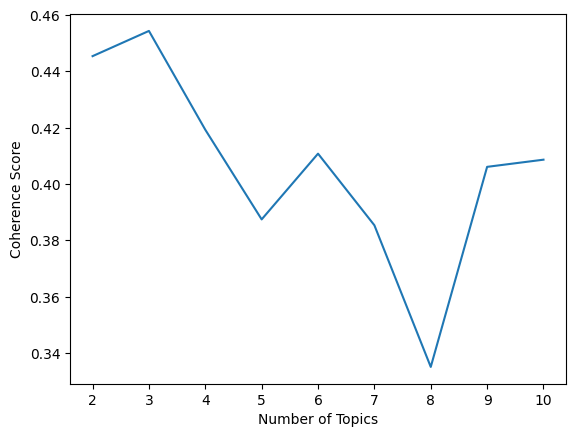

In [19]:
# Set the range of number of topics to try
min_topics = 2
max_topics = 10

# Create a list to store coherence scores for each number of topics
coherence_scores = []

# Iterate through different number of topics
for num_topics in range(min_topics, max_topics+1):
    
    print("Number of topics = " + str(num_topics))
    # Train the LDA model
    lda_model = LdaMulticore(corpus=doc_term_matrix,
                                                id2word=dictionary,
                                                num_topics=num_topics,
                                                random_state=42,
                                                passes=10,
                                                workers=multiprocessing.cpu_count(),
                                                alpha='asymmetric',
                                                eta='auto')

    print(*lda_model.print_topics(num_topics=num_topics), sep='\n')
    print()

    # Compute coherence score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=tweets_df['text_cleaned'], dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()
    
    # Add the coherence score to the list
    coherence_scores.append(coherence_score)


# Plot the coherence scores against number of topics
x = range(min_topics, max_topics+1)
plt.plot(x, coherence_scores)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.show()


Extreme Point

In [53]:
# Running and Trainign LDA model on the document term matrix.
ldamodel = LdaMulticore(doc_term_matrix, num_topics=9, id2word = dictionary, passes=10, workers = multiprocessing.cpu_count()-1) #2 topics
# Visualize
lda_display = gensimvis.prepare(ldamodel, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display)

Mid Coherence Point

In [54]:
# Running and Trainign LDA model on the document term matrix.
ldamodel = LdaMulticore(doc_term_matrix, num_topics=6, id2word = dictionary, passes=50, workers = multiprocessing.cpu_count()-1) #2 topics
# Visualize
lda_display = gensimvis.prepare(ldamodel, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display)

In [55]:
# Running and Trainign LDA model on the document term matrix.
ldamodel = LdaMulticore(doc_term_matrix, num_topics=4, id2word = dictionary, passes=10, workers = multiprocessing.cpu_count()-1) #2 topics
# Visualize
lda_display = gensimvis.prepare(ldamodel, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display)

In [56]:
# Running and Trainign LDA model on the document term matrix.
ldamodel = LdaMulticore(doc_term_matrix, num_topics=3, id2word = dictionary, passes=10, workers = multiprocessing.cpu_count()-1) #2 topics

# Visualize
lda_display = gensimvis.prepare(ldamodel, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display)

1. I cleaned the tweet data by removing the hashtags, mentions, URLs, newlines, punctuation and stop words and performed lemmatization using SpaCy only Pronouns, Nouns, Verbs and adjectives. Included Pronouns as otherwise the topics weren't interpretable. I didn't use bigrams and trigrams as the results weren't providing interpretable topics. 
2. I then compute the coherence scores for number of topics within the range 2-10 as I believe that since these are tweets, the topics won't be that long.
3.While the graph shows that 9 is the best N based on coherence scores, I believe <b>6 topics is the best N for tweets</b>. It has the following topics:
    - Microsoft and its softwares
    - Microsft's gaming companies - blizzard
    - Premium subscriptions under many applications like Microsoft, Spotify, Netflix
    - Courses on use of Microsoft apps
    - Stats about Microsoft and its CEO in the market
    - Companies like Microsoft and others have stopped in Russia dues to the war with Ukraine

## NEWS DATA

### Titles ONLY

In [24]:
news_df_1 = news_df.copy()
news_df_1['title_cleaned'] = news_df_1['title'].parallel_apply(clean_text)
news_df_1.head()

,url,date,language,title,text,title_cleaned
0,http://oaklandnewsnow.com/breaking-bts-announces-las-vegas-us-concert-date-in-2022/,2022-02-24,en,"BREAKING: BTS Announces LAS VEGAS, US Concert Date in 2022! | Oakland News Now - Oakland News, SF Bay Area, East Bay, California, World","BREAKING: BTS Announces LAS VEGAS, US Concert Date in 2022! | Oakland News Now - Oakland News, SF Bay Area, East Bay, California, WorldSorry, you have Javascript Disabled! To see this page as it is meant to appear, please enable your Javascript!BREAKING: BTS Announces LAS VEGAS, US Concert Date in 2022! | Oakland News Now - Oakland News, SF Bay Area, East Bay, California, WorldSkip to contentMenuSearch for:SearchOakland News Now – Oakland News, SF Bay Area, East Bay, California, WorldOakland...","[breaking, bts, announces, la, vega, u, concert, date, sf, bay, area, east, bay, california, world]"
1,http://www.newsdzezimbabwe.co.uk/2022/04/mai-tt-weds.html,2022-04-09,en,MAI TT WEDS newsdzeZimbabweNewsdzeZimbabwe,"MAI TT WEDS newsdzeZimbabweNewsdzeZimbabweskip to main | skip to sidebarHomeAboutContactAdvertiseNewsdzeZimbabweOur Zimbabwe Our NewsHomeNewsBusinessEntertainmentSaturday, 9 April 2022MAI TT WEDSSaturday, April 09, 2022 NewsdzeZimbabwe 0 Best moments... @Chakariboy @NyamayaroArron @restmutore @Lattynyangu pic.twitter.com/MsrhcFXUJj— H-Metro (@HMetro_) April 9, 2022 Posted in: Share to TwitterShare to FacebookOlder PostHome0comments: Post a CommentFollow NewsdzeZimbabweRecent...","[mai, tt, wed, newsdzezimbabwenewsdzezimbabwe]"
2,https://digg.com/video/heres-an-eye-popping-visualization-of-how-covid-19-enters-a-human-cell,2022-01-07,en,Here's An Eye-Popping Visualization Of How COVID-19 Enters A Human Cell - Digg,"Here's An Eye-Popping Visualization Of How COVID-19 Enters A Human Cell - DiggTrendingExploreMerchExploreMerchSign inClose menuGift GuidesVideoGamingPicksSportsLong ReadsTechCultureScienceRelationshipsSign in to your Digg account.Sign in with TwitterSign in with GoogleBy signing in you agree with ourcommunications and usage terms.Not a member yet? Sign up👋 Welcome to DiggThanks for creating an account! Your accounts lets you Digg (upvote) stories, save stories to revisit later, and more.📩 St...","[here, eyepopping, visualization, covid19, enters, human, cell, digg]"
3,https://economictimes.indiatimes.com/news/international/world-news/taliban-shut-down-schools-for-girls-just-hours-after-they-reopened/articleshow/90406043.cms,2022-03-23,en,taliban: Taliban shut down schools for girls just hours after they reopened - The Economic Times,"taliban: Taliban shut down schools for girls just hours after they reopened - The Economic Times Benchmarks Nifty17,245.65-69.85NSE Gainer-Large Cap Linde India3,508.05175.35FEATURED FUNDS★★★★★Mirae Asset Hybrid Equity Fund Direct-Growth5Y Return14.62 % Invest NowFEATURED FUNDS★★★★★Mirae Asset Equity Savings Fund Direct - Growth3Y Return13.38 % Invest NowMarket WatchNewsEnglish Edition | E-PaperSubscribeSign InET Prime starts @ Rs 49The Great Holi OfferUpgrade...","[taliban, taliban, shut, school, girl, hour, reopened]"
4,https://federalnewsnetwork.com/world-news/2022/06/scotland-leader-launches-campaign-for-new-independence-vote/,2022-06-14,en,Scotland leader launches campaign for new independence vote | Federal News Network,Scotland leader launches campaign for new independence vote | Federal News Network TechnologyArtificial IntelligenceAsk the CIOAutomationBig DataCIO NewsCloud ComputingCybersecurityIT ModernizationOpen Data/TransparencyReporter’s NotebookDefenseDoD Reporter’s NotebookOn DoDArmyNavyAir ForceDefense IndustryWorkforce/ManagementAcquisitionAgency OversightBudgetFacilities/ConstructionHiring/RetentionManagementPeopleReorganizationSESUnionsWorkforce Rights/GovernancePay & BenefitsBenefitsOpen Se...,"[scotland, leader, launch, campaign, new, independence, vote, network]"


In [57]:
# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(news_df_1['title_cleaned'])

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in news_df_1['title_cleaned']]

Number of topics = 2
(0, '0.006*"market" + 0.006*"new" + 0.005*"newsbreak" + 0.005*"microsoft" + 0.004*"stock" + 0.004*"fall" + 0.004*"share" + 0.004*"techradar" + 0.003*"inc" + 0.003*"u"')
(1, '0.005*"bay" + 0.004*"new" + 0.003*"world" + 0.003*"peoplecom" + 0.003*"east" + 0.003*"california" + 0.003*"area" + 0.003*"online" + 0.003*"million" + 0.003*"la"')

Number of topics = 3
(0, '0.006*"market" + 0.006*"microsoft" + 0.006*"new" + 0.006*"newsbreak" + 0.005*"stock" + 0.004*"techradar" + 0.004*"share" + 0.004*"fall" + 0.004*"game" + 0.004*"u"')
(1, '0.006*"new" + 0.005*"bay" + 0.004*"inc" + 0.004*"million" + 0.004*"peoplecom" + 0.004*"bnn" + 0.004*"bloomberg" + 0.004*"world" + 0.003*"california" + 0.003*"say"')
(2, '0.006*"market" + 0.005*"galleon" + 0.004*"global" + 0.004*"fall" + 0.004*"forecast" + 0.004*"january" + 0.003*"report" + 0.003*"impact" + 0.002*"industry" + 0.002*"digital"')

Number of topics = 4
(0, '0.006*"microsoft" + 0.006*"market" + 0.006*"newsbreak" + 0.006*"stock" + 

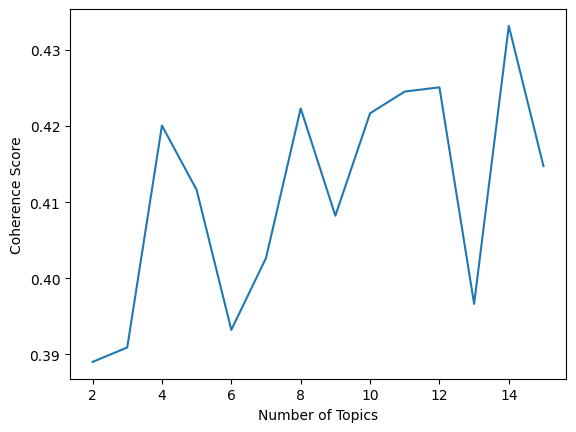

In [25]:
# Set the range of number of topics to try
min_topics = 2
max_topics = 15

# Create a list to store coherence scores for each number of topics
coherence_scores = []

# Iterate through different number of topics
for num_topics in range(min_topics, max_topics+1):
    
    print("Number of topics = " + str(num_topics))
    # Train the LDA model
    lda_model = LdaMulticore(corpus=doc_term_matrix,
                                                id2word=dictionary,
                                                num_topics=num_topics,
                                                random_state=42,
                                                passes=10,
                                                workers=multiprocessing.cpu_count(),
                                                alpha='asymmetric',
                                                eta='auto')

    print(*lda_model.print_topics(num_topics=num_topics), sep='\n')
    print()

    # Compute coherence score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=news_df_1['title_cleaned'], dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()
    
    # Add the coherence score to the list
    coherence_scores.append(coherence_score)


# Plot the coherence scores against number of topics
x = range(min_topics, max_topics+1)
plt.plot(x, coherence_scores)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.show()


In [58]:
# Running and Trainign LDA model on the document term matrix.
ldamodel = LdaMulticore(doc_term_matrix, num_topics=14, id2word = dictionary, passes=10, workers = multiprocessing.cpu_count()-1) #2 topics
# Visualize
lda_display = gensimvis.prepare(ldamodel, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display)

In [59]:
# Running and Trainign LDA model on the document term matrix.
ldamodel = LdaMulticore(doc_term_matrix, num_topics=12, id2word = dictionary, passes=10, workers = multiprocessing.cpu_count()-1) #2 topics

# Visualize
lda_display = gensimvis.prepare(ldamodel, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display)

In [60]:
# Running and Trainign LDA model on the document term matrix.
ldamodel = LdaMulticore(doc_term_matrix, num_topics=11, id2word = dictionary, passes=10, workers = multiprocessing.cpu_count()-1) #2 topics

# Visualize
lda_display = gensimvis.prepare(ldamodel, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display)

In [61]:
# Running and Trainign LDA model on the document term matrix.
ldamodel = LdaMulticore(doc_term_matrix, num_topics=10, id2word = dictionary, passes=10, workers = multiprocessing.cpu_count()-1) #2 topics
# Visualize
lda_display = gensimvis.prepare(ldamodel, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display)

In [62]:
# Running and Trainign LDA model on the document term matrix.
ldamodel = LdaMulticore(doc_term_matrix, num_topics=8, id2word = dictionary, passes=10, workers = multiprocessing.cpu_count()-1) #2 topics

lda_display = gensimvis.prepare(ldamodel, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display)

In [63]:
# Running and Trainign LDA model on the document term matrix.
ldamodel = LdaMulticore(doc_term_matrix, num_topics=7, id2word = dictionary, passes=10, workers = multiprocessing.cpu_count()-1) #2 topics

lda_display = gensimvis.prepare(ldamodel, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display)

In [64]:
# Running and Trainign LDA model on the document term matrix.
ldamodel = LdaMulticore(doc_term_matrix, num_topics=6, id2word = dictionary, passes=10, workers = multiprocessing.cpu_count()-1) #2 topics

lda_display = gensimvis.prepare(ldamodel, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display)

1. I cleaned the news title data by removing the hashtags, mentions, URLs, newlines, punctuation and stop words and performed lemmatization. I didn't use bigrams and trigrams as the results weren't providing interpretable topics. 
2. I then compute the coherence scores for number of topics within the range 3-15 as I believe that since these are news titles, the topics will be long.
3.While the graph shows that 14 is the best N based on coherence scores, I believe <b>6 topics is the best N for news titles</b>. It has the following topics:
    - Wall street reports on the market
    - Pages to visit
    - Stock Market Analysis for Jan and Feb
    - Launch of businesses
    - Software companies and their stocks
    - Microsoft's game business
    

# TEXT

In [31]:
news_df_2 = news_df.copy()
news_df_2['text_cleaned'] = news_df_2['text'].parallel_apply(clean_text)
news_df_2.head()

,url,date,language,title,text,text_cleaned
0,http://oaklandnewsnow.com/breaking-bts-announces-las-vegas-us-concert-date-in-2022/,2022-02-24,en,"BREAKING: BTS Announces LAS VEGAS, US Concert Date in 2022! | Oakland News Now - Oakland News, SF Bay Area, East Bay, California, World","BREAKING: BTS Announces LAS VEGAS, US Concert Date in 2022! | Oakland News Now - Oakland News, SF Bay Area, East Bay, California, WorldSorry, you have Javascript Disabled! To see this page as it is meant to appear, please enable your Javascript!BREAKING: BTS Announces LAS VEGAS, US Concert Date in 2022! | Oakland News Now - Oakland News, SF Bay Area, East Bay, California, WorldSkip to contentMenuSearch for:SearchOakland News Now – Oakland News, SF Bay Area, East Bay, California, WorldOakland...","[breaking, bts, announces, la, vega, u, concert, date, sf, bay, area, east, bay, california, worldsorry, javascript, disabled, see, page, meant, appear, please, enable, javascriptbreaking, bts, announces, la, vega, u, concert, date, sf, bay, area, east, bay, california, worldskip, contentmenusearch, sf, bay, area, east, bay, california, youtube, aggregator, home, author, lake, merritt, alley, cat, grand, lake, theater, bartlett, law, zennie62, youtube, channel, vloggers, page, comic, con, sd..."
1,http://www.newsdzezimbabwe.co.uk/2022/04/mai-tt-weds.html,2022-04-09,en,MAI TT WEDS newsdzeZimbabweNewsdzeZimbabwe,"MAI TT WEDS newsdzeZimbabweNewsdzeZimbabweskip to main | skip to sidebarHomeAboutContactAdvertiseNewsdzeZimbabweOur Zimbabwe Our NewsHomeNewsBusinessEntertainmentSaturday, 9 April 2022MAI TT WEDSSaturday, April 09, 2022 NewsdzeZimbabwe 0 Best moments... @Chakariboy @NyamayaroArron @restmutore @Lattynyangu pic.twitter.com/MsrhcFXUJj— H-Metro (@HMetro_) April 9, 2022 Posted in: Share to TwitterShare to FacebookOlder PostHome0comments: Post a CommentFollow NewsdzeZimbabweRecent...","[mai, tt, wed, newsdzezimbabwenewsdzezimbabweskip, main, skip, sidebarhomeaboutcontactadvertisenewsdzezimbabweour, zimbabwe, newshomenewsbusinessentertainmentsaturday, april, 2022mai, tt, wedssaturday, april, newsdzezimbabwe, best, moment, pictwittercommsrhcfxujj, hmetro, april, posted, post, commentfollow, newsdzezimbabwerecent, commentspowered, disqusfollow, newsdzezimbabwepopular, poststycoon, bed, mother, daughtera, woman, bulawayo, left, shocked, heartbroken, discovering, husband, local..."
2,https://digg.com/video/heres-an-eye-popping-visualization-of-how-covid-19-enters-a-human-cell,2022-01-07,en,Here's An Eye-Popping Visualization Of How COVID-19 Enters A Human Cell - Digg,"Here's An Eye-Popping Visualization Of How COVID-19 Enters A Human Cell - DiggTrendingExploreMerchExploreMerchSign inClose menuGift GuidesVideoGamingPicksSportsLong ReadsTechCultureScienceRelationshipsSign in to your Digg account.Sign in with TwitterSign in with GoogleBy signing in you agree with ourcommunications and usage terms.Not a member yet? Sign up👋 Welcome to DiggThanks for creating an account! Your accounts lets you Digg (upvote) stories, save stories to revisit later, and more.📩 St...","[here, eyepopping, visualization, covid19, enters, human, cell, diggtrendingexploremerchexploremerchsign, inclose, menugift, guidesvideogamingpickssportslong, readstechculturesciencerelationshipssign, digg, accountsign, twittersign, googleby, signing, agree, ourcommunications, usage, termsnot, member, yet, sign, welcome, diggthanks, creating, account, account, let, digg, upvote, story, save, story, revisit, later, stay, uptodateemail, sent, select, newsletter, youd, like, receive, change, su..."
3,https://economictimes.indiatimes.com/news/international/world-news/taliban-shut-down-schools-for-girls-just-hours-after-they-reopened/articleshow/90406043.cms,2022-03-23,en,taliban: Taliban shut down schools for girls just hours after they reopened - The Economic Times,"taliban: Taliban shut down schools for girls just hours after they reopened - The Economic Times Benchmarks Nifty17,245.65-69.85NSE Gainer-Large 

In [65]:
# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(news_df_2['text_cleaned'])

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in news_df_2['text_cleaned']]


Number of topics = 3
(0, '0.005*"new" + 0.004*"market" + 0.004*"u" + 0.003*"company" + 0.003*"year" + 0.003*"game" + 0.002*"data" + 0.002*"best" + 0.002*"said" + 0.002*"also"')
(1, '0.008*"share" + 0.008*"stock" + 0.007*"company" + 0.006*"inc" + 0.006*"ago" + 0.005*"market" + 0.004*"day" + 0.004*"price" + 0.003*"hour" + 0.003*"new"')
(2, '0.014*"video" + 0.013*"music" + 0.011*"official" + 0.007*"new" + 0.005*"song" + 0.003*"la" + 0.003*"black" + 0.003*"de" + 0.003*"star" + 0.002*"show"')

Number of topics = 4
(0, '0.006*"market" + 0.004*"new" + 0.004*"u" + 0.004*"company" + 0.003*"stock" + 0.003*"year" + 0.003*"said" + 0.003*"data" + 0.003*"day" + 0.003*"business"')
(1, '0.019*"video" + 0.017*"music" + 0.016*"official" + 0.007*"song" + 0.006*"new" + 0.005*"share" + 0.003*"v" + 0.003*"oakland" + 0.003*"stock" + 0.003*"history"')
(2, '0.011*"new" + 0.009*"open" + 0.008*"de" + 0.006*"tab" + 0.006*"la" + 0.006*"link" + 0.004*"people" + 0.004*"que" + 0.004*"en" + 0.003*"el"')
(3, '0.006*"ne

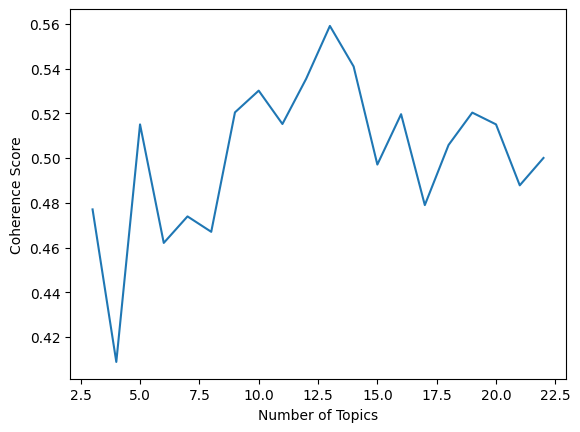

In [32]:
# Set the range of number of topics to try
min_topics = 3
max_topics = 22

# Create a list to store coherence scores for each number of topics
coherence_scores = []

# Iterate through different number of topics
for num_topics in range(min_topics, max_topics+1):
    
    print("Number of topics = " + str(num_topics))
    # Train the LDA model
    lda_model = LdaMulticore(corpus=doc_term_matrix,
                                                id2word=dictionary,
                                                num_topics=num_topics,
                                                random_state=42,
                                                passes=10,
                                                workers=os.cpu_count()-1,
                                                alpha='asymmetric',
                                                eta='auto')

    print(*lda_model.print_topics(num_topics=num_topics), sep='\n')
    print()

    # Compute coherence score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=news_df_2['text_cleaned'], dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()
    
    # Add the coherence score to the list
    coherence_scores.append(coherence_score)


# Plot the coherence scores against number of topics
x = range(min_topics, max_topics+1)
plt.plot(x, coherence_scores)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.show()


In [66]:
# Running and Trainign LDA model on the document term matrix.
ldamodel = LdaMulticore(doc_term_matrix, num_topics=13, id2word = dictionary, passes=10, workers = multiprocessing.cpu_count()-1) #2 topics

lda_display = gensimvis.prepare(ldamodel, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display)

In [67]:
# Running and Trainign LDA model on the document term matrix.
ldamodel = LdaMulticore(doc_term_matrix, num_topics=10, id2word = dictionary, passes=10, workers = multiprocessing.cpu_count()-1) #2 topics

lda_display = gensimvis.prepare(ldamodel, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display)

In [69]:
# Running and Trainign LDA model on the document term matrix.
ldamodel = LdaMulticore(doc_term_matrix, num_topics=7, id2word = dictionary, passes=10, workers = multiprocessing.cpu_count()) #2 topics

lda_display = gensimvis.prepare(ldamodel, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display)

1. I cleaned the news text data by removing the hashtags, mentions, URLs, newlines, punctuation and stop words and performed lemmatization. I didn't use bigrams and trigrams as the results weren't providing interpretable topics. 
2. I then compute the coherence scores for number of topics within the range 3-22 as I believe that since these are news articles, the topics will be long.
3.While the graph shows that 13 is the best N based on coherence scores, I believe <b>7 topics is the best N for news titles</b>. It has the following topics:
    - Wall street reports on the market
    - Pages to visit
    - Cookie info
    - Release of music video
    - New business products
    - Time
    - Stock market
    

TITLE + TEXT

In [34]:
news_df_3 = news_df.copy()
news_df_3['combined'] = news_df_3['title'] + news_df_3['text']
news_df_3['text_cleaned'] = news_df_3['combined'].parallel_apply(clean_text)
news_df_3.head()

,url,date,language,title,text,combined,text_cleaned
0,http://oaklandnewsnow.com/breaking-bts-announces-las-vegas-us-concert-date-in-2022/,2022-02-24,en,"BREAKING: BTS Announces LAS VEGAS, US Concert Date in 2022! | Oakland News Now - Oakland News, SF Bay Area, East Bay, California, World","BREAKING: BTS Announces LAS VEGAS, US Concert Date in 2022! | Oakland News Now - Oakland News, SF Bay Area, East Bay, California, WorldSorry, you have Javascript Disabled! To see this page as it is meant to appear, please enable your Javascript!BREAKING: BTS Announces LAS VEGAS, US Concert Date in 2022! | Oakland News Now - Oakland News, SF Bay Area, East Bay, California, WorldSkip to contentMenuSearch for:SearchOakland News Now – Oakland News, SF Bay Area, East Bay, California, WorldOakland...","BREAKING: BTS Announces LAS VEGAS, US Concert Date in 2022! | Oakland News Now - Oakland News, SF Bay Area, East Bay, California, WorldBREAKING: BTS Announces LAS VEGAS, US Concert Date in 2022! | Oakland News Now - Oakland News, SF Bay Area, East Bay, California, WorldSorry, you have Javascript Disabled! To see this page as it is meant to appear, please enable your Javascript!BREAKING: BTS Announces LAS VEGAS, US Concert Date in 2022! | Oakland News Now - Oakland News, SF Bay Area, East Bay...","[breaking, bts, announces, la, vega, u, concert, date, sf, bay, area, east, bay, california, worldbreaking, bts, announces, la, vega, u, concert, date, sf, bay, area, east, bay, california, worldsorry, javascript, disabled, see, page, meant, appear, please, enable, javascriptbreaking, bts, announces, la, vega, u, concert, date, sf, bay, area, east, bay, california, worldskip, contentmenusearch, sf, bay, area, east, bay, california, youtube, aggregator, home, author, lake, merritt, alley, cat..."
1,http://www.newsdzezimbabwe.co.uk/2022/04/mai-tt-weds.html,2022-04-09,en,MAI TT WEDS newsdzeZimbabweNewsdzeZimbabwe,"MAI TT WEDS newsdzeZimbabweNewsdzeZimbabweskip to main | skip to sidebarHomeAboutContactAdvertiseNewsdzeZimbabweOur Zimbabwe Our NewsHomeNewsBusinessEntertainmentSaturday, 9 April 2022MAI TT WEDSSaturday, April 09, 2022 NewsdzeZimbabwe 0 Best moments... @Chakariboy @NyamayaroArron @restmutore @Lattynyangu pic.twitter.com/MsrhcFXUJj— H-Metro (@HMetro_) April 9, 2022 Posted in: Share to TwitterShare to FacebookOlder PostHome0comments: Post a CommentFollow NewsdzeZimbabweRecent...","MAI TT WEDS newsdzeZimbabweNewsdzeZimbabweMAI TT WEDS newsdzeZimbabweNewsdzeZimbabweskip to main | skip to sidebarHomeAboutContactAdvertiseNewsdzeZimbabweOur Zimbabwe Our NewsHomeNewsBusinessEntertainmentSaturday, 9 April 2022MAI TT WEDSSaturday, April 09, 2022 NewsdzeZimbabwe 0 Best moments... @Chakariboy @NyamayaroArron @restmutore @Lattynyangu pic.twitter.com/MsrhcFXUJj— H-Metro (@HMetro_) April 9, 2022 Posted in: Share to TwitterShare to FacebookOlder PostHome0comments: ...","[mai, tt, wed, newsdzezimbabwenewsdzezimbabwemai, tt, wed, newsdzezimbabwenewsdzezimbabweskip, main, skip, sidebarhomeaboutcontactadvertisenewsdzezimbabweour, zimbabwe, newshomenewsbusinessentertainmentsaturday, april, 2022mai, tt, wedssaturday, april, newsdzezimbabwe, best, moment, pictwittercommsrhcfxujj, hmetro, april, posted, post, commentfollow, newsdzezimbabwerecent, commentspowered, disqusfollow, newsdzezimbabwepopular, poststycoon, bed, mother, daughtera, woman, bulawayo, left, shock..."
2,https://digg.com/video/heres-an-eye-popping-visualization-of-how-covid-19-enters-a-human-cell,2022-01-07,en,Here's An Eye-Popping Visualization Of How COVID-19 Enters A Human Cell - Digg,"Here's An Eye-Popping Visualization Of How COVID-19 Enters A Human Cell - DiggTrendingExploreMerchExploreMerchSign inClose menuGift GuidesVideoGamingPicksSportsLong ReadsTechCultureScienceRelationshipsSign in to your Digg account.Sign in with TwitterSign in with GoogleBy signing in you agree with ourcommunications and usage terms.Not a member yet? Sign up👋 Welcome to DiggThanks for creating an account! Your accounts lets 

In [70]:
# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(news_df_3['text_cleaned'])

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in news_df_3['text_cleaned']]

Number of topics = 3
(0, '0.006*"market" + 0.005*"new" + 0.004*"company" + 0.004*"stock" + 0.004*"u" + 0.003*"day" + 0.003*"said" + 0.003*"service" + 0.003*"share" + 0.003*"year"')
(1, '0.006*"new" + 0.004*"best" + 0.003*"game" + 0.003*"cookie" + 0.003*"u" + 0.003*"user" + 0.003*"get" + 0.003*"set" + 0.002*"may" + 0.002*"one"')
(2, '0.014*"video" + 0.013*"music" + 0.011*"official" + 0.006*"new" + 0.005*"song" + 0.004*"la" + 0.003*"share" + 0.003*"black" + 0.003*"de" + 0.002*"year"')

Number of topics = 4
(0, '0.007*"market" + 0.004*"company" + 0.004*"new" + 0.003*"u" + 0.003*"service" + 0.003*"business" + 0.003*"data" + 0.003*"said" + 0.003*"product" + 0.003*"report"')
(1, '0.006*"new" + 0.004*"best" + 0.004*"cookie" + 0.004*"game" + 0.003*"u" + 0.003*"user" + 0.003*"set" + 0.003*"get" + 0.003*"pm" + 0.003*"may"')
(2, '0.020*"video" + 0.017*"music" + 0.016*"official" + 0.007*"song" + 0.006*"new" + 0.004*"share" + 0.004*"la" + 0.004*"de" + 0.003*"v" + 0.003*"oakland"')
(3, '0.007*"new" 

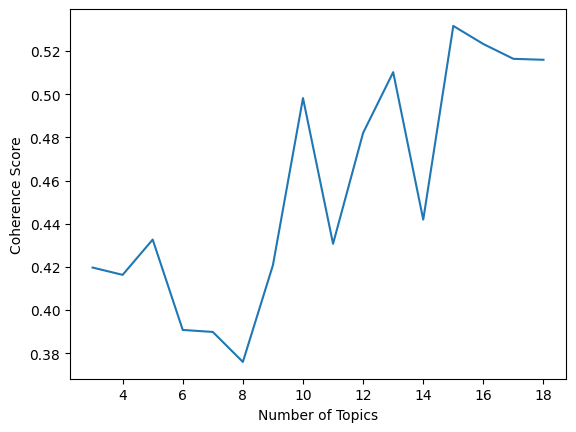

In [35]:
# Set the range of number of topics to try
min_topics = 3
max_topics = 18

# Create a list to store coherence scores for each number of topics
coherence_scores = []

# Iterate through different number of topics
for num_topics in range(min_topics, max_topics+1):
    
    print("Number of topics = " + str(num_topics))
    # Train the LDA model
    lda_model = LdaMulticore(corpus=doc_term_matrix,
                                                id2word=dictionary,
                                                num_topics=num_topics,
                                                random_state=42,
                                                passes=10,
                                                workers=multiprocessing.cpu_count(),
                                                alpha='asymmetric',
                                                eta='auto')

    print(*lda_model.print_topics(num_topics=num_topics), sep='\n')
    print()

    # Compute coherence score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=news_df_3['text_cleaned'], dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()
    
    # Add the coherence score to the list
    coherence_scores.append(coherence_score)


# Plot the coherence scores against number of topics
x = range(min_topics, max_topics+1)
plt.plot(x, coherence_scores)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.show()


In [71]:
# Running and Trainign LDA model on the document term matrix.
ldamodel = LdaMulticore(doc_term_matrix, num_topics=7, id2word = dictionary, passes=10, workers = multiprocessing.cpu_count()) #2 topics

lda_display = gensimvis.prepare(ldamodel, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display)

The title and text combo produces same results as text alone so 7 is the ideal number for news articles. It has the following topics:<br>
-   Wall street reports on the market
-   Pages to visit
-   Cookie info
-   Release of music video
-   New business products
-   Time
-   Stock market
    